<a href="https://colab.research.google.com/github/chad-fisher/KansasWind/blob/main/KansasWindfarms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [100]:
# Install needed packages on environment
!pip install matplotlib_scalebar contextily wget rasterstats rioxarray geocube

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 146.4/146.4 kB 2.7 MB/s eta 0:00:00


In [2]:
# Install spatial RF package from GitHub
!pip install git+https://github.com/mie-lab/spatial_rf_python.git#egg=sprf

  Cloning https://github.com/mie-lab/spatial_rf_python.git to /tmp/pip-install-0msz9zps/sprf_98f9f4f7f41240b7bd0f2cb94ce5570d
  Running command git clone --filter=blob:none --quiet https://github.com/mie-lab/spatial_rf_python.git /tmp/pip-install-0msz9zps/sprf_98f9f4f7f41240b7bd0f2cb94ce5570d
  Resolved https://github.com/mie-lab/spatial_rf_python.git to commit 20d88253883492d81e62ae550a01ff2b8aaeed26
  Preparing metadata (setup.py) ... done
  Created wheel for sprf: filename=sprf-0.0.1-py3-none-any.whl size=9870 sha256=8c0ed53ee3919a0815388a75c67b3ff77c9de075e4069e1a7f2d2890b487a153
  Stored in directory: /tmp/pip-ephem-wheel-cache-2p5gqk7s/wheels/8b/86/d5/fb2c74a3279dd89ff1d61d803d6aa49e21319509e573968048
Successfully built sprf


In [2]:
#Import packages
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
import scipy

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar

import contextily as cx

import rasterio as rio
from rasterio.plot import show
from rasterio.mask import mask
from rasterio.merge import merge
from rasterio.enums import Resampling
from rasterio.warp import calculate_default_transform, reproject, Resampling

import wget
import zipfile
import datetime
import urllib
import rasterstats
import glob

import sprf
from sprf.spatial_random_forest import SpatialRandomForest
from sprf.geographical_random_forest import GeographicalRandomForest

import rioxarray as rxr
import xarray
import fiona

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

from shapely.geometry import Point

from geocube.api.core import make_geocube

In [4]:
# Get Cleaned Data from ArcGIS
!wget "https://tufts.box.com/shared/static/jr0cmw6ft5vvkd8gkdjcexva5pfqsald.zip"
zipfile.ZipFile('/content/jr0cmw6ft5vvkd8gkdjcexva5pfqsald.zip').extractall()

--2024-04-22 13:10:23--  https://tufts.box.com/shared/static/jr0cmw6ft5vvkd8gkdjcexva5pfqsald.zip
Resolving tufts.box.com (tufts.box.com)... 74.112.186.144
Connecting to tufts.box.com (tufts.box.com)|74.112.186.144|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/jr0cmw6ft5vvkd8gkdjcexva5pfqsald.zip [following]
--2024-04-22 13:10:24--  https://tufts.box.com/public/static/jr0cmw6ft5vvkd8gkdjcexva5pfqsald.zip
Reusing existing connection to tufts.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://tufts.app.box.com/public/static/jr0cmw6ft5vvkd8gkdjcexva5pfqsald.zip [following]
--2024-04-22 13:10:24--  https://tufts.app.box.com/public/static/jr0cmw6ft5vvkd8gkdjcexva5pfqsald.zip
Resolving tufts.app.box.com (tufts.app.box.com)... 74.112.186.144
Connecting to tufts.app.box.com (tufts.app.box.com)|74.112.186.144|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https:/

# Data Collection and Cleaning

## Wind Turbine Data

In [5]:
#Get Wind Turbine Data
!wget "https://eerscmap.usgs.gov/uswtdb/assets/data/uswtdbSHP.zip"
zipfile.ZipFile('uswtdbSHP.zip').extractall(path='/content/WTDB')

--2024-04-22 13:11:34--  https://eerscmap.usgs.gov/uswtdb/assets/data/uswtdbSHP.zip
Resolving eerscmap.usgs.gov (eerscmap.usgs.gov)... 137.227.248.56, 2001:49c8:0:126d::56
Connecting to eerscmap.usgs.gov (eerscmap.usgs.gov)|137.227.248.56|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4265263 (4.1M) [application/zip]
Saving to: ‘uswtdbSHP.zip’

uswtdbSHP.zip       100%[===================>]   4.07M  11.4MB/s    in 0.4s    

2024-04-22 13:11:35 (11.4 MB/s) - ‘uswtdbSHP.zip’ saved [4265263/4265263]



In [4]:
# Open, subset, and reproject KS WT
path='/content/WTDB/uswtdb_v6_1_20231128.shp'
KS_WT = gpd.read_file(path)[gpd.read_file(path)['t_state'] == 'KS']
KansasWindTurbines_Reprojected = KS_WT.to_crs(epsg=3857)

## State Data

In [41]:
# Get State outlines from census
!wget "https://www2.census.gov/geo/tiger/TIGER2023/STATE/tl_2023_us_state.zip"
zipfile.ZipFile('tl_2023_us_state.zip').extractall(path='/content/States')

--2024-04-22 13:36:56--  https://www2.census.gov/geo/tiger/TIGER2023/STATE/tl_2023_us_state.zip
Resolving www2.census.gov (www2.census.gov)... 96.17.84.71, 2600:1408:20:394::208c, 2600:1408:20:395::208c
Connecting to www2.census.gov (www2.census.gov)|96.17.84.71|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘tl_2023_us_state.zip’

tl_2023_us_state.zi     [ <=>                ]   9.49M  58.1MB/s    in 0.2s    

2024-04-22 13:36:57 (58.1 MB/s) - ‘tl_2023_us_state.zip’ saved [9947818]



In [33]:
StatesMap = gpd.read_file('/content/States/tl_2023_us_state.shp')

In [34]:
# Extract Kansas boundaries
KS_StateMap = StatesMap[StatesMap['NAME'] == 'Kansas']

,REGION,DIVISION,STATEFP,STATENS,GEOID,GEOIDFQ,STUSPS,NAME,LSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
47,2,4,20,00481813,20,0400000US20,KS,Kansas,00,G4000,A,211753777631,1345707708,+38.4985464,-098.3834298,"POLYGON ((-94.61764 37.76124, -94.61766 37.760..."


## Wind Turbine Map

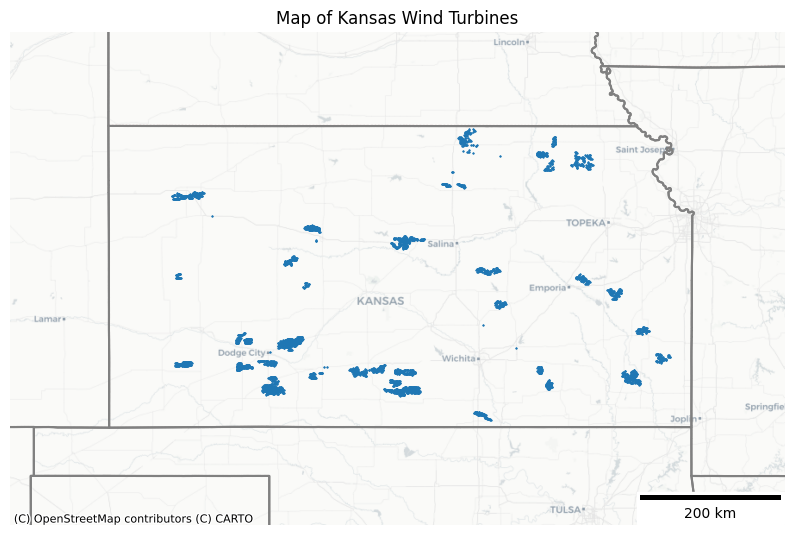

In [ ]:
# Generate map
ax = KS_WT.to_crs(epsg=3857).plot(figsize=(10,10),marker='*',markersize=0.5)
StatesMap.to_crs(epsg=3857).boundary.plot(ax=ax, color = 'gray')

#Change zoom/extent of map using coordinates in relevant CRS
plt.xlim(-1.15e7, -1.04e7)
plt.ylim(4.3e6, 5e6)

#Modify and save map
plt.title("Map of Kansas Wind Turbines")
cx.add_basemap(ax,source=cx.providers.CartoDB.Positron)
ax.set_axis_off()
ax.add_artist(ScaleBar(1,location='lower right'))
plt.savefig("KansasWindTurbinesMap.png")

## Land Cover Data

In [ ]:
# Get NLCD data
!wget "https://s3-us-west-2.amazonaws.com/mrlc/nlcd_2021_land_cover_l48_20230630.zip"
zipfile.ZipFile('nlcd_2021_land_cover_l48_20230630.zip').extractall(path='/content/LandCover')

--2024-04-22 04:43:10--  https://s3-us-west-2.amazonaws.com/mrlc/nlcd_2021_land_cover_l48_20230630.zip
Resolving s3-us-west-2.amazonaws.com (s3-us-west-2.amazonaws.com)... 52.92.185.144, 52.218.153.104, 52.218.176.112, ...
Connecting to s3-us-west-2.amazonaws.com (s3-us-west-2.amazonaws.com)|52.92.185.144|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1958811487 (1.8G) [application/zip]
Saving to: ‘nlcd_2021_land_cover_l48_20230630.zip’

nlcd_2021_land_cove 100%[===================>]   1.82G  61.9MB/s    in 32s     

2024-04-22 04:43:42 (58.1 MB/s) - ‘nlcd_2021_land_cover_l48_20230630.zip’ saved [1958811487/1958811487]



In [45]:
#open cleaned image from ArcGIS
KS_LandCover,trans = rio.mask.mask(rio.open('/content/Cleaned Data/KS_NLCD_Cleaned.tif'),KS_StateMap.to_crs(epsg=3857).geometry,crop=True, filled=False)

In [46]:
# Recode NLCD database codes to make them evenly spaced
recode=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]
nlcd_codes = [0, 11, 12, 21, 22, 23, 24, 31, 41, 42, 43, 52, 71, 81, 82, 90, 95]
for i in recode:
  KS_LandCover[KS_LandCover==nlcd_codes[i]]=i

In [47]:
# Create custom colormap based on recoded values
nlcd_colors = ['#ffffff', '#476ba0', '#d1def8', '#decaca', '#d99482', '#ee0000', '#ab0000',
               '#b3aea3', '#68ab63', '#1c6330', '#b5ca8f', '#a68c30', '#ccba7d', '#e3e3c2',
               '#caca78', '#99c247', '#78ae94']

cmap = mpl.colors.ListedColormap(nlcd_colors)
norm = mpl.colors.BoundaryNorm(recode,
                    len(nlcd_colors))

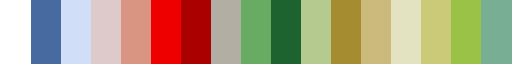

In [48]:
#Test colormap
cmap

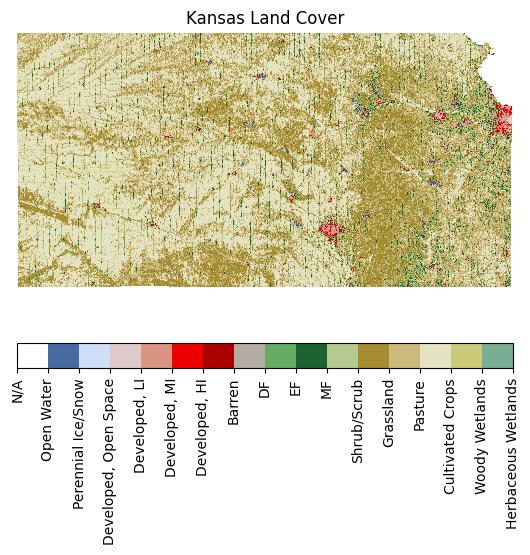

In [50]:
#Initialize plot
fig, ax = plt.subplots()
plt.title('Kansas Land Cover')

# Create hidden image for colorbar and actual image
hidden=ax.imshow(KS_LandCover[0,:,:],cmap=cmap,norm=norm)
show(KS_LandCover,ax=ax,cmap=cmap,norm=norm)
cbar= fig.colorbar(hidden, ticks=recode, ax=ax,location='bottom')
labels=['N/A','Open Water','Perennial Ice/Snow','Developed, Open Space','Developed, LI','Developed, MI','Developed, HI','Barren','DF','EF','MF','Shrub/Scrub','Grassland','Pasture','Cultivated Crops','Woody Wetlands','Herbaceous Wetlands']
cbar.set_ticks(ticks=recode,labels=labels)
cbar.ax.tick_params(rotation=90)

#Save plot as png
ax.set_axis_off()
fig.savefig('Kansas Land Cover.png')

## Wind Speed Data

In [ ]:
# Download wind speed data
!wget 'https://globalwindatlas3.s3-eu-west-1.amazonaws.com/country_tifs/USA_wind-speed_10m.tif'

--2024-04-22 04:50:40--  https://globalwindatlas3.s3-eu-west-1.amazonaws.com/country_tifs/USA_wind-speed_10m.tif
Resolving globalwindatlas3.s3-eu-west-1.amazonaws.com (globalwindatlas3.s3-eu-west-1.amazonaws.com)... 52.218.105.179, 3.5.71.247, 3.5.69.159, ...
Connecting to globalwindatlas3.s3-eu-west-1.amazonaws.com (globalwindatlas3.s3-eu-west-1.amazonaws.com)|52.218.105.179|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 702896032 (670M) [image/tiff]
Saving to: ‘USA_wind-speed_10m.tif’

USA_wind-speed_10m. 100%[===================>] 670.33M  19.8MB/s    in 35s     

2024-04-22 04:51:16 (19.3 MB/s) - ‘USA_wind-speed_10m.tif’ saved [702896032/702896032]



In [ ]:
# Mask windspeed data
with rio.open('/content/USA_wind-speed_10m.tif') as src:
    out_meta = src.meta
    out_image, out_transform = rio.mask.mask(src, shapes=KS_StateMap.to_crs(4326).geometry, crop=True)


    profile = src.profile
    profile["height"] = out_image.shape[1]
    profile["width"] = out_image.shape[2]
    profile["transform"] = out_transform


    out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})

with rio.open("wind2023.tif", "w", **out_meta) as dest:
    dest.write(out_image)

In [ ]:
#Reproject windspeed data
dst_crs = 'EPSG:3857'

with rio.open('wind2023.tif') as src:

    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds)
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height
    })
    with rio.Env(CHECK_DISK_FREE_SPACE="NO"):
        with rio.open('/content/WindSpeed_Reprojected.tif', 'w', **kwargs) as dst:
            for i in range(1, src.count + 1):
                reproject(
                    source=rio.band(src, i),
                    destination=rio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=dst_crs,
                    resampling=Resampling.nearest)

In [ ]:
#Open reprojected and masked data
wind2023 = rio.open('WindSpeed_Reprojected.tif').read(1)

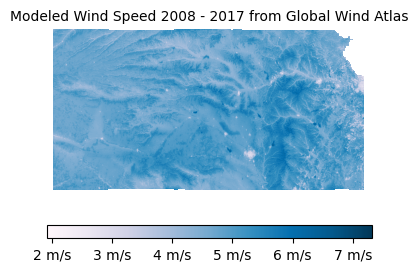

In [ ]:
#Initialize plot
fig, ax =plt.subplots(figsize=(6,3))
plt.title('Modeled Wind Speed 2008 - 2017 from Global Wind Atlas',size = 'medium')

# Create hidden image for colorbar and actual image
hidden = ax.imshow(wind2023,cmap = 'PuBu')
img = show(wind2023, ax = ax, cmap = 'PuBu')
fig.colorbar(hidden, cmap = 'PuBu', shrink=.7, orientation = 'horizontal', aspect = 25, format = "%i m/s")

# Save plot
ax.axis('off')
fig.savefig('Wind Kansas Map')

## DEM Data

In [ ]:
# Download DEM tiles
!wget 'https://tufts.box.com/shared/static/ti9me4c794p69w51ztfedwsu3au0r2qg.zip'
zipfile.ZipFile('/content/ti9me4c794p69w51ztfedwsu3au0r2qg.zip').extractall()

--2024-04-22 04:51:18--  https://tufts.box.com/shared/static/ti9me4c794p69w51ztfedwsu3au0r2qg.zip
Resolving tufts.box.com (tufts.box.com)... 74.112.186.144
Connecting to tufts.box.com (tufts.box.com)|74.112.186.144|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/ti9me4c794p69w51ztfedwsu3au0r2qg.zip [following]
--2024-04-22 04:51:18--  https://tufts.box.com/public/static/ti9me4c794p69w51ztfedwsu3au0r2qg.zip
Reusing existing connection to tufts.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://tufts.app.box.com/public/static/ti9me4c794p69w51ztfedwsu3au0r2qg.zip [following]
--2024-04-22 04:51:18--  https://tufts.app.box.com/public/static/ti9me4c794p69w51ztfedwsu3au0r2qg.zip
Resolving tufts.app.box.com (tufts.app.box.com)... 74.112.186.144
Connecting to tufts.app.box.com (tufts.app.box.com)|74.112.186.144|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https:/

In [ ]:
# Mosaic tiles
DEM_list=glob.glob('/content/DEM/*.tif')
src_files_to_mosaic = []
for fp in DEM_list:
  src = rio.open(fp)
  src_files_to_mosaic.append(src)
mosaic, out_trans = merge(src_files_to_mosaic)
out_meta = src.meta.copy()
out_meta.update({"driver": "GTiff",
"height": mosaic.shape[1],
"width": mosaic.shape[2],"transform": out_trans,"crs": "+proj=longlat +datum=WGS84 +no_defs"})

with rio.open("mosaic.tif", "w", **out_meta) as dest:
    dest.write(mosaic)

In [ ]:
# tiles exported into ArcGIS and cleaned

In [ ]:
# Import cleaned DEM mosaic
mos = rio.open('/content/Cleaned Data/DEM_Cleaned.tif')

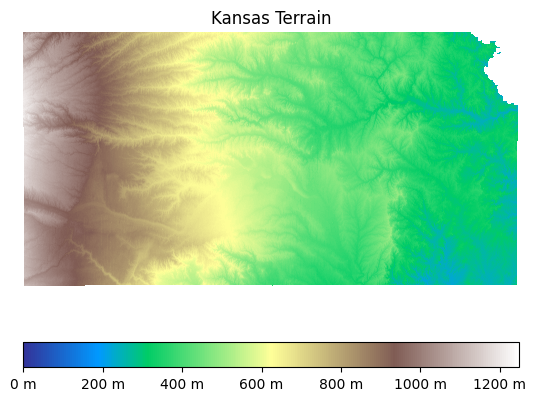

In [ ]:
# Initialize plots
fig,ax=plt.subplots()

# Mask to Kansas
mosaic,trans=rio.mask.mask(mos, shapes=KS_StateMap.to_crs(3857).geometry, crop=True,filled=False,nodata=0)
plt.title('Kansas Terrain',size='large')

# Create hidden image for colorbar and actual image
hidden=ax.imshow(mosaic[0,:,:],cmap='terrain',vmin=0)
show(mosaic,cmap='terrain',ax=ax,vmin=0)
fig.colorbar(hidden,cmap='terrain',orientation='horizontal',format="%i m")

# Save plot
ax.axis('off')
fig.savefig('Terrain Map.png')

## Power Lines Data

In [ ]:
# Download power lines data
!wget 'https://tufts.box.com/shared/static/lw7aasw5fvm7z60l6qh1p75h92bzt4j4.zip'
zipfile.ZipFile('/content/lw7aasw5fvm7z60l6qh1p75h92bzt4j4.zip').extractall(path = 'PowerLines')

--2024-04-22 04:53:13--  https://tufts.box.com/shared/static/lw7aasw5fvm7z60l6qh1p75h92bzt4j4.zip
Resolving tufts.box.com (tufts.box.com)... 74.112.186.144
Connecting to tufts.box.com (tufts.box.com)|74.112.186.144|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/lw7aasw5fvm7z60l6qh1p75h92bzt4j4.zip [following]
--2024-04-22 04:53:13--  https://tufts.box.com/public/static/lw7aasw5fvm7z60l6qh1p75h92bzt4j4.zip
Reusing existing connection to tufts.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://tufts.app.box.com/public/static/lw7aasw5fvm7z60l6qh1p75h92bzt4j4.zip [following]
--2024-04-22 04:53:13--  https://tufts.app.box.com/public/static/lw7aasw5fvm7z60l6qh1p75h92bzt4j4.zip
Resolving tufts.app.box.com (tufts.app.box.com)... 74.112.186.144
Connecting to tufts.app.box.com (tufts.app.box.com)|74.112.186.144|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https:/

In [ ]:
# Read power lines data
powerLines = gpd.read_file('/content/PowerLines/Electric_Power_Transmission_Lines_A.shp')

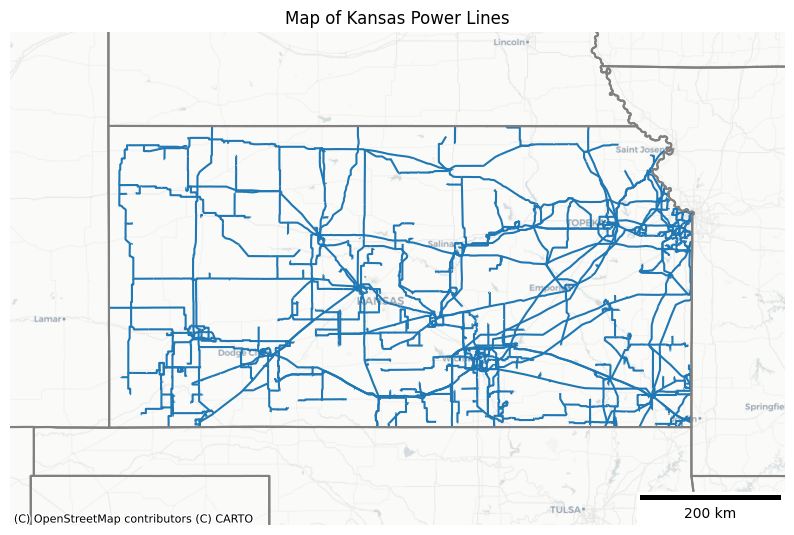

In [ ]:
# Make map
ax = powerLines.to_crs(epsg=3857).clip(KS_StateMap.to_crs(epsg=3857)).plot(figsize=(10,10))
StatesMap.to_crs(epsg=3857).boundary.plot(ax=ax, color = 'gray')

# Change zoom
plt.xlim(-1.15e7, -1.04e7)
plt.ylim(4.3e6, 5e6)

# Finalize and save
plt.title("Map of Kansas Power Lines")
cx.add_basemap(ax,source=cx.providers.CartoDB.Positron)
ax.set_axis_off()
ax.add_artist(ScaleBar(1,location='lower right'))
plt.savefig("Kansas Power Lines.png")

## Population Density Data

In [ ]:
# Get population density shapefiles and table
!wget 'https://tufts.box.com/shared/static/vnp1c8e89ct7n5ugrp978nz8iqk32qgv.zip'
zipfile.ZipFile('/content/vnp1c8e89ct7n5ugrp978nz8iqk32qgv.zip').extractall(path = 'PopData')

--2024-04-22 04:53:21--  https://tufts.box.com/shared/static/vnp1c8e89ct7n5ugrp978nz8iqk32qgv.zip
Resolving tufts.box.com (tufts.box.com)... 74.112.186.144
Connecting to tufts.box.com (tufts.box.com)|74.112.186.144|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/vnp1c8e89ct7n5ugrp978nz8iqk32qgv.zip [following]
--2024-04-22 04:53:21--  https://tufts.box.com/public/static/vnp1c8e89ct7n5ugrp978nz8iqk32qgv.zip
Reusing existing connection to tufts.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://tufts.app.box.com/public/static/vnp1c8e89ct7n5ugrp978nz8iqk32qgv.zip [following]
--2024-04-22 04:53:21--  https://tufts.app.box.com/public/static/vnp1c8e89ct7n5ugrp978nz8iqk32qgv.zip
Resolving tufts.app.box.com (tufts.app.box.com)... 74.112.186.144
Connecting to tufts.app.box.com (tufts.app.box.com)|74.112.186.144|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https:/

In [ ]:
# table from https://data.census.gov/table/ACSDT5Y2022.B01001?t=Populations%20and%20People&g=040XX00US20$1500000&y=2022

In [ ]:
# Read data
Pop_Data=pd.read_csv('/content/PopData/PopData/PopData.csv')
KS_BG=gpd.read_file('/content/PopData/PopData/tl_2023_20_bg.shp')

In [ ]:
# Fix GEOIDs to match for join
Pop_Data['Fix_ID']=Pop_Data['GEO_ID'].str[-7:]
KS_BG['ID']=KS_BG['GEOIDFQ'].str[-7:]

In [ ]:
# Attribute join
KS_Pop = KS_BG.merge(Pop_Data, left_on='ID',right_on='Fix_ID')

In [ ]:
# Calculate population density using joined data
KS_Pop['PopDens']=KS_Pop['Total_Pop']/KS_Pop['ALAND']

In [ ]:
# Find maximum value
KS_Pop['PopDens'].max()

0.020095422435367945

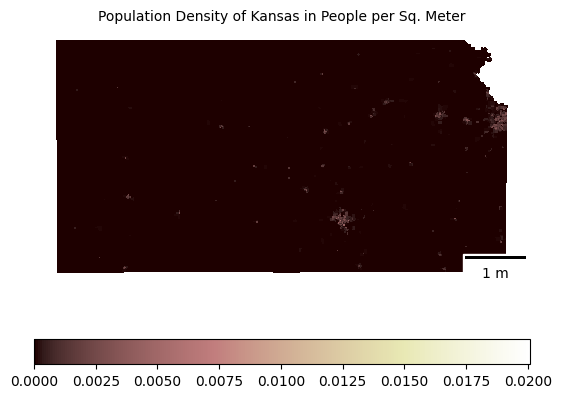

In [ ]:
# Plot data
fig,ax=plt.subplots()
KS_Pop.plot(column='PopDens',legend=True,cmap='pink',ax=ax,legend_kwds={'location':'bottom'},antialiased=False)

#Finalize and save
ax.axis('off')
plt.title('Population Density of Kansas in People per Sq. Meter',fontdict={'fontsize': 10})
ax.add_artist(ScaleBar(1,location='lower right'))
fig.savefig('Population Density.png')

## Annual Precipitation

In [30]:
!wget 'https://tufts.box.com/shared/static/whdmmxe2guifgcou5ho9w5ko0gn7lwgo.zip'
zipfile.ZipFile('/content/whdmmxe2guifgcou5ho9w5ko0gn7lwgo.zip').extractall(path='AnnualPrecipitation')

--2024-04-22 13:15:13--  https://tufts.box.com/shared/static/whdmmxe2guifgcou5ho9w5ko0gn7lwgo.zip
Resolving tufts.box.com (tufts.box.com)... 74.112.186.144
Connecting to tufts.box.com (tufts.box.com)|74.112.186.144|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/whdmmxe2guifgcou5ho9w5ko0gn7lwgo.zip [following]
--2024-04-22 13:15:13--  https://tufts.box.com/public/static/whdmmxe2guifgcou5ho9w5ko0gn7lwgo.zip
Reusing existing connection to tufts.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://tufts.app.box.com/public/static/whdmmxe2guifgcou5ho9w5ko0gn7lwgo.zip [following]
--2024-04-22 13:15:13--  https://tufts.app.box.com/public/static/whdmmxe2guifgcou5ho9w5ko0gn7lwgo.zip
Resolving tufts.app.box.com (tufts.app.box.com)... 74.112.186.144
Connecting to tufts.app.box.com (tufts.app.box.com)|74.112.186.144|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https:/

In [28]:
annual_precip = pd.read_csv('/content/AnnualPrecipitation/AnnualPrecipitation/PrecipTotal-2023.csv')
UScounties = gpd.read_file('/content/AnnualPrecipitation/AnnualPrecipitation/tl_2023_us_county.shp')

In [ ]:
annual_precip

,County,Year,Total
0,Allen,2023,28.92
1,Anderson,2023,29.48
2,Atchison,2023,30.45
3,Barber,2023,32.87
4,Barton,2023,24.75
...,...,...,...
100,Washington,2023,23.78
101,Wichita,2023,22.63
102,Wilson,2023,30.59
103,Woodson,2023,27.34


In [32]:
UScounties

,STATEFP,COUNTYFP,COUNTYNS,GEOID,GEOIDFQ,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,31,039,00835841,31039,0500000US31039,Cuming,Cuming County,06,H1,G4020,None,None,None,A,1477563029,10772508,+41.9158651,-096.7885168,"POLYGON ((-96.55515 41.91587, -96.55515 41.914..."
1,53,069,01513275,53069,0500000US53069,Wahkiakum,Wahkiakum County,06,H1,G4020,None,None,None,A,680980771,61564427,+46.2946377,-123.4244583,"POLYGON ((-123.72755 46.26449, -123.72755 46.2..."
2,35,011,00933054,35011,0500000US35011,De Baca,De Baca County,06,H1,G4020,None,None,None,A,6016818946,29090018,+34.3592729,-104.3686961,"POLYGON ((-104.89337 34.08894, -104.89337 34.0..."
3,31,109,00835876,31109,0500000US31109,Lancaster,Lancaster County,06,H1,G4020,339,30700,None,A,2169269688,22850324,+40.7835474,-096.6886584,"POLYGON ((-96.68493 40.52330, -96.69219 40.523..."
4,31,129,00835886,31129,0500000US31129,Nuckolls,Nuckolls County,06,H1,G4020,None,None,None,A,1489645187,1718484,+40.1764918,-098.0468422,"POLYGON ((-98.27370 40.11840, -98.27374 40.122..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3230,13,123,00351260,13123,0500000US13123,Gilmer,Gilmer County,06,H1,G4020,None,None,None,A,1103893380,12276629,+34.6905232,-084.4548113,"POLYGON ((-84.30237 34.57832, -84.30329 34.577..."
3231,27,135,00659513,27135,0500000US27135,Roseau,Roseau County,06,H1,G4020,None,None,None,A,4329782924,16924046,+48.7610683,-095.8215042,"POLYGON ((-95.25857 48.88666, -95.25707 48.885..."
3232,28,089,00695768,28089,0500000US28089,Madison,Madison County,06,H1,G4020,298,27140,None,A,1849790735,72085470,+32.6343703,-090.0341603,"POLYGON ((-90.14883 32.40026, -90.14890 32.400..."
3233,48,227,01383899,48227,0500000US48227,Howard,Howard County,06,H1,G4020,None,13700,None,A,2333039148,8841781,+32.3034298,-101.4387208,"POLYGON ((-101.18138 32.21252, -101.18138 32.2..."


In [29]:
KS_counties = UScounties[UScounties['STATEFP'] == '20']

In [ ]:
KS_counties

,STATEFP,COUNTYFP,COUNTYNS,GEOID,GEOIDFQ,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
60,20,073,00485003,20073,0500000US20073,Greenwood,Greenwood County,06,H1,G4020,None,None,None,A,2961143637,24145021,+37.8793472,-096.2417321,"POLYGON ((-96.35809 38.08638, -96.35808 38.088..."
69,20,043,00484991,20043,0500000US20043,Doniphan,Doniphan County,06,H1,G4020,312,41140,None,A,1019096302,12433564,+39.7885021,-095.1472253,"POLYGON ((-95.02152 39.67065, -95.02243 39.670..."
77,20,157,00485042,20157,0500000US20157,Republic,Republic County,06,H1,G4020,None,None,None,A,1857998455,7951912,+39.8289061,-097.6508830,"POLYGON ((-97.36923 39.91492, -97.36923 39.912..."
111,20,039,00484989,20039,0500000US20039,Decatur,Decatur County,06,H1,G4020,None,None,None,A,2314199321,1631670,+39.7835420,-100.4597084,"POLYGON ((-100.74008 39.91620, -100.73992 39.9..."
151,20,147,00485037,20147,0500000US20147,Phillips,Phillips County,06,H1,G4020,None,None,None,A,2294395646,22493383,+39.7845058,-099.3421498,"POLYGON ((-99.29091 40.00195, -99.29080 40.002..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3084,20,155,00485041,20155,0500000US20155,Reno,Reno County,06,H1,G4020,None,26740,None,A,3251231985,43517492,+37.9481849,-098.0783463,"POLYGON ((-97.80782 37.73385, -97.80811 37.733..."
3123,20,069,00485001,20069,0500000US20069,Gray,Gray County,06,H1,G4020,None,None,None,A,2250356175,1113338,+37.7445134,-100.4517163,"POLYGON ((-100.22732 37.85590, -100.22749 37.8..."
3160,20,197,00485059,20197,0500000US20197,Wabaunsee,Wabaunsee County,06,H1,G4020,None,45820,None,A,2057320865,13845234,+38.9551537,-096.2012619,"POLYGON ((-96.18664 38.73898, -96.19208 38.738..."
3202,20,173,00485049,20173,0500000US20173,Sedgwick,Sedgwick County,06,H1,G4020,556,48620,None,A,2582220576,31390123,+37.6810450,-097.4610535,"POLYGON ((-97.36901 37.47727, -97.36919 37.477..."


In [ ]:
KS_counties_precip = KS_counties.merge(annual_precip, left_on='NAME',right_on='County')

In [ ]:
KS_counties_precip

,STATEFP,COUNTYFP,COUNTYNS,GEOID,GEOIDFQ,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,...,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,County,Year,Total
0,20,073,00485003,20073,0500000US20073,Greenwood,Greenwood County,06,H1,G4020,...,None,A,2961143637,24145021,+37.8793472,-096.2417321,"POLYGON ((-96.35809 38.08638, -96.35808 38.088...",Greenwood,2023,27.45
1,20,043,00484991,20043,0500000US20043,Doniphan,Doniphan County,06,H1,G4020,...,None,A,1019096302,12433564,+39.7885021,-095.1472253,"POLYGON ((-95.02152 39.67065, -95.02243 39.670...",Doniphan,2023,31.71
2,20,157,00485042,20157,0500000US20157,Republic,Republic County,06,H1,G4020,...,None,A,1857998455,7951912,+39.8289061,-097.6508830,"POLYGON ((-97.36923 39.91492, -97.36923 39.912...",Republic,2023,22.06
3,20,039,00484989,20039,0500000US20039,Decatur,Decatur County,06,H1,G4020,...,None,A,2314199321,1631670,+39.7835420,-100.4597084,"POLYGON ((-100.74008 39.91620, -100.73992 39.9...",Decatur,2023,21.09
4,20,147,00485037,20147,0500000US20147,Phillips,Phillips County,06,H1,G4020,...,None,A,2294395646,22493383,+39.7845058,-099.3421498,"POLYGON ((-99.29091 40.00195, -99.29080 40.002...",Phillips,2023,19.56
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,20,155,00485041,20155,0500000US20155,Reno,Reno County,06,H1,G4020,...,None,A,3251231985,43517492,+37.9481849,-098.0783463,"POLYGON ((-97.80782 37.73385, -97.80811 37.733...",Reno,2023,26.29
101,20,069,00485001,20069,0500000US20069,Gray,Gray County,06,H1,G4020,...,None,A,2250356175,1113338,+37.7445134,-100.4517163,"POLYGON ((-100.22732 37.85590, -100.22749 37.8...",Gray,2023,25.34
102,20,197,00485059,20197,0500000US20197,Wabaunsee,Wabaunsee County,06,H1,G4020,...,None,A,2057320865,13845234,+38.9551537,-096.2012619,"POLYGON ((-96.18664 38.73898, -96.19208 38.738...",Wabaunsee,2023,27.73
103,20,173,00485049,20173,0500000US20173,Sedgwick,Sedgwick County,06,H1,G4020,...,None,A,2582220576,31390123,+37.6810450,-097.4610535,"POLYGON ((-97.36901 37.47727, -97.36919 37.477...",Sedgwick,2023,28.86


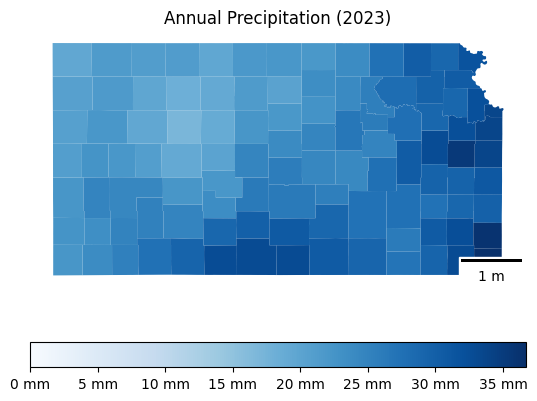

In [ ]:
fig,ax=plt.subplots()
KS_counties_precip.plot(column='Total',legend=True,legend_kwds={'location':'bottom','format':'%i mm'},cmap='Blues',ax=ax,vmin=0)
ax.axis('off')
plt.title('Annual Precipitation (2023)',fontdict={'fontsize': 12})
ax.add_artist(ScaleBar(1,location='lower right'))
fig.savefig('Precipitation.png')

# Export to ArcGIS for reprojecting, rasterizing, and resampling

In [ ]:
# ArcGIS saves the day

In [ ]:
KS_counties_precip.to_file('KS_Counties.shp')

In [ ]:
KS_Pop.to_file('PopDens.shp')

In [ ]:
with rio.open('/content/LandCover/nlcd_2021_land_cover_l48_20230630.img') as src:
    out_meta = src.meta
    out_image, out_transform = rio.mask.mask(src, shapes=KS_StateMap.to_crs(src.crs).geometry, crop=True)


    profile = src.profile
    profile["height"] = out_image.shape[1]
    profile["width"] = out_image.shape[2]
    profile["transform"] = out_transform


    out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})

with rio.open("Ks_NLCD.tif", "w", **out_meta) as dest:
    dest.write(out_image)

In [ ]:
with rio.open('/content/DEM/ASTGTMV003_N36W094_dem.tif') as src:
    out_meta = src.meta
    profile = src.profile
    profile["height"] = mosaic.shape[1]
    profile["width"] = mosaic.shape[2]
    profile["transform"] = out_trans


    out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})

with rio.open("mosaic.tif", "w", **out_meta) as dest:
    dest.write(out_image)

In [ ]:
with rio.open('/content/USA_wind-speed_10m.tif') as src:
    out_meta = src.meta
    out_image, out_transform = rio.mask.mask(src, shapes=KS_StateMap.to_crs(4326).geometry, crop=True)


    profile = src.profile
    profile["height"] = out_image.shape[1]
    profile["width"] = out_image.shape[2]
    profile["transform"] = out_transform


    out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})

with rio.open("wind2023.tif", "w", **out_meta) as dest:
    dest.write(out_image)

In [ ]:
#Will clean and reproject in ArcGIS
#See ArcPy notebook here: https://tufts.box.com/shared/static/4gwnz8xlch37qkyh8q6j9zg18ckactux.ipynb

# Land Cover = 10%
# Elevation - 5%
# Distance to Power Lines - 30%
# Population - 10%
# Rainfall - 5%
# Wind Speed - 40%

#Classic Suitability Analysis in ArcPy

With counties outlines: https://tufts.box.com/s/40sj0pld19p6s1h62l9tahpf0adbg0wh

Without counties outlines: https://tufts.box.com/s/6tkk4v96feeu90ab227imgkb3jqyuzw9

# Spatial Random Forest

## Setup and bring in cleaned data

In [6]:
KansasWindTurbines_Reprojected=KansasWindTurbines_Reprojected[KansasWindTurbines_Reprojected['p_cap']>0]

In [7]:
KansasWindTurbines_Reprojected['Avg_Cap']=KansasWindTurbines_Reprojected['p_cap']/KansasWindTurbines_Reprojected['p_tnum']

In [8]:
sites = KansasWindTurbines_Reprojected[['Avg_Cap','geometry']]

<Axes: >

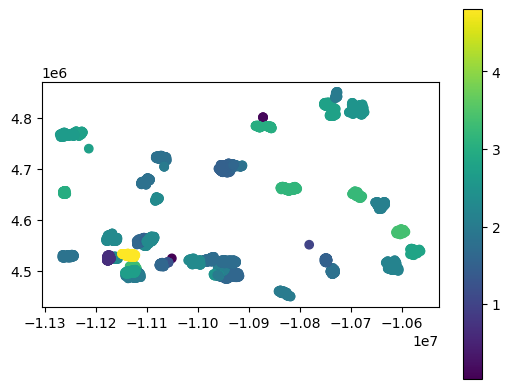

In [9]:
sites.plot(column='Avg_Cap',cmap='viridis',legend=True)

In [10]:
sites['x'] = sites['geometry'].x
sites['y'] = sites['geometry'].y

/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [11]:
sites.index = range(len(sites))
coords = [(x,y) for x, y in zip(sites.x, sites.y)]
src1 = rio.open('/content/Cleaned Data/DEM_Cleaned.tif')
src2 = rio.open('/content/Cleaned Data/Distance_PL.tif')
src3 = rio.open('/content/Cleaned Data/KS_NLCD_Cleaned.tif')
src4 = rio.open('/content/Cleaned Data/PopDensity.tif')
src5 = rio.open('/content/Cleaned Data/Precip.tif')
src6 = rio.open('/content/Cleaned Data/wind2023_proj.tif')

sites['DEM'] = [x[0] for x in src1.sample(coords)]
sites['Dist_PL']= [x[0] for x in src2.sample(coords)]
sites['LC']= [x[0] for x in src3.sample(coords)]
sites['PopDens'] = [x[0] for x in src4.sample(coords)]
sites['Precip'] = [x[0] for x in src5.sample(coords)]
sites['Wind']= [x[0] for x in src6.sample(coords)]

/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

In [12]:
sites=sites.drop('geometry',axis=1)

In [13]:
sites

,Avg_Cap,x,y,DEM,Dist_PL,LC,PopDens,Precip,Wind
0,2.30,-1.108088e+07,4.638251e+06,680,782.304260,22,6.039340e-07,20.10,5.049803
1,2.30,-1.108143e+07,4.644064e+06,646,3693.291260,82,6.039340e-07,20.10,4.961378
2,2.30,-1.108140e+07,4.638107e+06,682,553.172668,23,6.039340e-07,20.10,4.959997
3,2.30,-1.108336e+07,4.636672e+06,707,296.984863,23,6.039340e-07,20.10,5.729786
4,2.30,-1.108289e+07,4.636742e+06,698,593.969727,71,6.039340e-07,20.10,5.483709
...,...,...,...,...,...,...,...,...,...
3922,2.30,-1.109556e+07,4.563943e+06,728,3251.230469,23,7.784790e-07,24.92,5.079025
3923,2.30,-1.109352e+07,4.555606e+06,713,4397.328613,23,7.784790e-07,24.92,4.975652
3924,2.30,-1.109866e+07,4.557537e+06,732,1380.000000,22,7.784790e-07,24.92,5.098150
3925,2.30,-1.109752e+07,4.557741e+06,730,1170.000000,82,7.784790e-07,24.92,5.146365


In [14]:
# Determine total number of examples, and number of examples in train and test sets
frac_test=0.3
rng = np.random.default_rng(seed=121)
L=sites.shape[0]
M=int(L*(1-frac_test))
N=int(L*frac_test)

In [15]:
# Randomly select the indices for the needed number of examples from the set for train
train_indices=rng.choice(np.arange(0,L), size = M, replace = False, p = None)

# The test indices are the other rows that were not selected
test_indices=np.arange(0,L)[~np.isin(np.arange(0,L),train_indices)]

# Use indices to generate final arrays
train=sites.iloc[train_indices]
test=sites.iloc[test_indices]

In [16]:
test

,Avg_Cap,x,y,DEM,Dist_PL,LC,PopDens,Precip,Wind
0,2.30,-1.108088e+07,4.638251e+06,680,782.304260,22,6.039340e-07,20.10,5.049803
1,2.30,-1.108143e+07,4.644064e+06,646,3693.291260,82,6.039340e-07,20.10,4.961378
5,2.30,-1.108040e+07,4.643623e+06,647,2651.735352,23,6.039340e-07,20.10,4.817434
14,2.30,-1.107934e+07,4.643226e+06,640,1633.554443,82,6.039340e-07,20.10,4.785051
15,2.30,-1.107988e+07,4.639891e+06,676,381.837677,82,6.039340e-07,20.10,4.944125
...,...,...,...,...,...,...,...,...,...
3917,2.30,-1.108844e+07,4.557716e+06,713,8094.998535,23,7.784790e-07,24.92,4.996145
3918,2.30,-1.108557e+07,4.564266e+06,695,9595.920898,82,7.784790e-07,24.92,4.930735
3919,2.30,-1.108992e+07,4.559558e+06,711,6543.370605,22,7.784790e-07,24.92,4.853770
3921,2.30,-1.109969e+07,4.556058e+06,735,2850.000000,22,7.784790e-07,24.92,5.068526


In [17]:
train

,Avg_Cap,x,y,DEM,Dist_PL,LC,PopDens,Precip,Wind
2406,3.000000,-1.088373e+07,4.783409e+06,492,3945.884033,82,1.194910e-06,23.44,5.554372
961,2.300000,-1.117474e+07,4.569146e+06,840,7920.000000,22,1.161240e-06,25.34,4.919495
288,1.850000,-1.124949e+07,4.526135e+06,927,2250.000000,82,9.020200e-07,24.97,4.780914
2830,3.377627,-1.060582e+07,4.576051e+06,334,14624.038086,81,2.773640e-06,28.92,5.162526
2698,1.500000,-1.093880e+07,4.698949e+06,542,3871.046387,82,2.199480e-06,23.85,5.231543
...,...,...,...,...,...,...,...,...,...
716,2.000000,-1.112816e+07,4.489820e+06,784,1020.000000,82,6.869710e-07,29.32,5.406147
2911,2.300000,-1.101155e+07,4.514401e+06,623,15985.806641,82,9.214780e-07,29.85,5.100811
593,2.000000,-1.111573e+07,4.491666e+06,771,1790.474854,82,6.869710e-07,29.32,5.376225
3200,1.800000,-1.091629e+07,4.705440e+06,523,7376.401367,22,7.325480e-07,21.99,6.141890


In [18]:
def prepare_data(data, target, lon="x", lat="y"):
    """Assumes that all other columns are used as covariates"""
    covariates = [col for col in data.columns if col not in [lon, lat, target]]
    return data[covariates], data[target], data[[lon, lat]]

In [19]:
# split into x, y and coordinates
train_x, train_y, train_coords = prepare_data(
    train, 'Avg_Cap'
)
test_x, test_y, test_coords = prepare_data(
    test, 'Avg_Cap'
)

In [20]:
n_estimators = 100
max_depth = 10
spatial_neighbors = len(sites) // 5

In [21]:
rf = RandomForestRegressor(max_depth=max_depth)
rf.fit(train_x, train_y)
test_pred_rf = rf.predict(test_x)

rmse_rf = mean_squared_error(test_pred_rf, test_y, squared=False)
print("Error of basic Random Forest: ", rmse_rf)

Error of basic Random Forest:  0.2222953023792536


In [22]:
sp = SpatialRandomForest(
    max_depth=max_depth, neighbors=spatial_neighbors
)
sp.fit(train_x, train_y, train_coords)
test_pred_sp = sp.predict(test_x, test_coords)

rmse_spatial_rf = mean_squared_error(test_pred_sp, test_y, squared=False)
print("Error of spatial Random Forest: ", rmse_spatial_rf)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Error of spatial Random Forest:  0.341793434546976


In [23]:
regr = SpatialRandomForest(
        n_estimators=n_estimators, neighbors=500, max_depth=max_depth
    )
regr.tune_neighbors(train_x, train_y, train_coords)
print("spatial rf tuned:", regr.neighbors)
regr.fit(train_x, train_y, train_coords)
test_pred_tune = regr.predict(test_x, test_coords)
rmse_spatial_rf_tuned = mean_squared_error(test_pred_tune, test_y, squared=False)
print("Error of tuned spatial Random Forest: ", rmse_spatial_rf_tuned)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

spatial rf tuned: 2498


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Error of tuned spatial Random Forest:  0.26601863512453117


In [24]:
test['RFPrediction']=test_pred_rf
test['SPRFPrediction']=test_pred_sp
test['TunePrediction']=test_pred_tune

<ipython-input-24-7fe65372d85b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['RFPrediction']=test_pred_rf
<ipython-input-24-7fe65372d85b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['SPRFPrediction']=test_pred_sp
<ipython-input-24-7fe65372d85b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

In [25]:
test_gdf = gpd.GeoDataFrame(
    test, geometry=gpd.points_from_xy(test.x, test.y), crs="EPSG:3857"
)

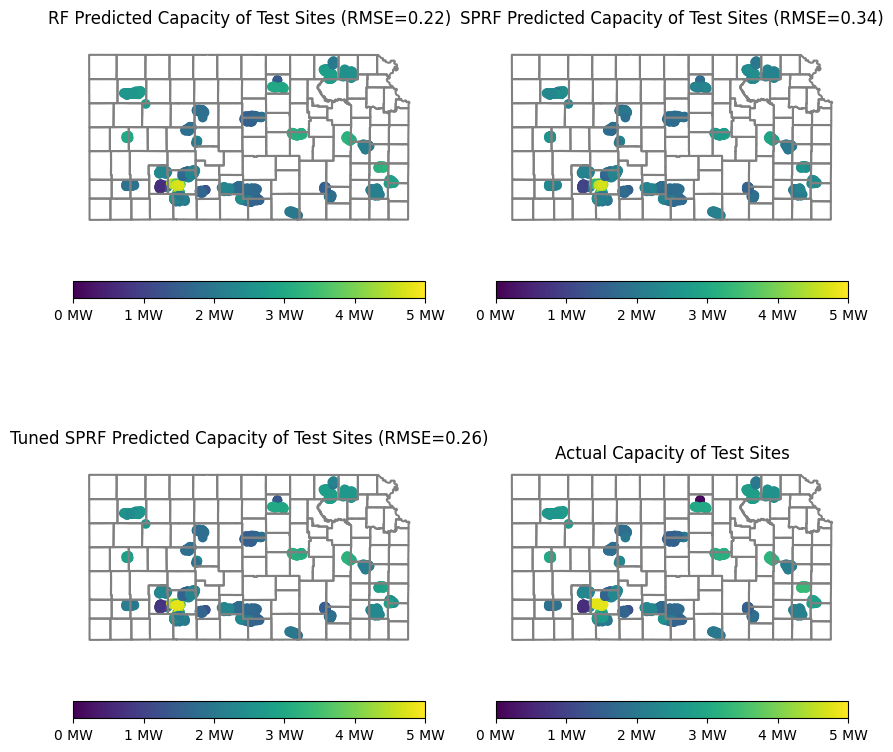

In [30]:
fig,ax=plt.subplots(2,2,figsize=(10,10))

test_gdf.plot(column='RFPrediction',ax=ax[0,0],legend=True,legend_kwds={'location':'bottom','format':'%i MW'},vmin=0,vmax=5)
KS_counties.to_crs(epsg=3857).boundary.plot(ax=ax[0,0], color = 'gray')
ax[0,0].axis('off')
ax[0,0].set_title('RF Predicted Capacity of Test Sites'+' (RMSE='+str(rmse_rf)[:4]+')')

test_gdf.plot(column='SPRFPrediction',ax=ax[0,1],legend=True,legend_kwds={'location':'bottom','format':'%i MW'},vmin=0,vmax=5)
KS_counties.to_crs(epsg=3857).boundary.plot(ax=ax[0,1], color = 'gray')
ax[0,1].axis('off')
ax[0,1].set_title('SPRF Predicted Capacity of Test Sites'+' (RMSE='+str(rmse_spatial_rf)[:4]+')')

test_gdf.plot(column='TunePrediction',ax=ax[1,0],legend=True,legend_kwds={'location':'bottom','format':'%i MW'},vmin=0,vmax=5)
KS_counties.to_crs(epsg=3857).boundary.plot(ax=ax[1,0], color = 'gray')
ax[1,0].axis('off')
ax[1,0].set_title('Tuned SPRF Predicted Capacity of Test Sites'+' (RMSE='+str(rmse_spatial_rf_tuned)[:4]+')')

test_gdf.plot(column='Avg_Cap',ax=ax[1,1],legend=True,legend_kwds={'location':'bottom','format':'%i MW'},vmin=0,vmax=5)
KS_counties.to_crs(epsg=3857).boundary.plot(ax=ax[1,1], color = 'gray')
ax[1,1].axis('off')
ax[1,1].set_title('Actual Capacity of Test Sites')

fig.savefig('Predicted Capacity.png')

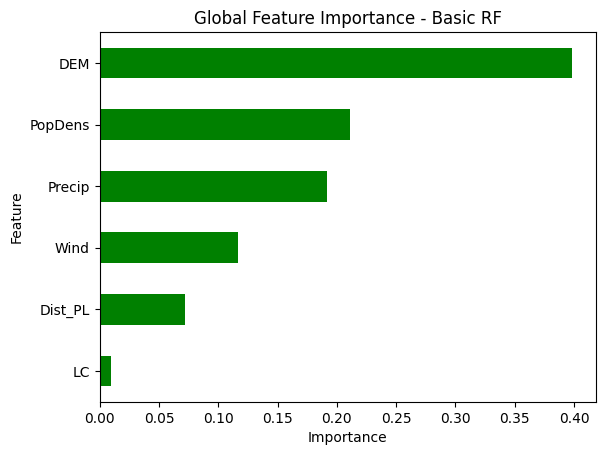

In [31]:
global_importances = pd.Series(rf.feature_importances_, index=train_x.columns)
global_importances.sort_values(ascending=True, inplace=True)
global_importances[-10:].plot.barh(color='green')
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Global Feature Importance - Basic RF")
plt.savefig('Feature Importance.png')

## Create Points for each pixel in raster

Will generate a square tesselation in ArcGIS but for 600 x 600m squares to reduce storage size and then generate their centroids and import as prediction sites (still took 40+ mins)

## Predict with RF regressor

In [53]:
!wget https://tufts.box.com/shared/static/2nw88pxderrdcadkcwo16y08t7shaxn2.zip
zipfile.ZipFile('2nw88pxderrdcadkcwo16y08t7shaxn2.zip').extractall('/content/ValidationPoints')

--2024-04-22 14:58:01--  https://tufts.box.com/shared/static/2nw88pxderrdcadkcwo16y08t7shaxn2.zip
Resolving tufts.box.com (tufts.box.com)... 74.112.186.144
Connecting to tufts.box.com (tufts.box.com)|74.112.186.144|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/2nw88pxderrdcadkcwo16y08t7shaxn2.zip [following]
--2024-04-22 14:58:01--  https://tufts.box.com/public/static/2nw88pxderrdcadkcwo16y08t7shaxn2.zip
Reusing existing connection to tufts.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://tufts.app.box.com/public/static/2nw88pxderrdcadkcwo16y08t7shaxn2.zip [following]
--2024-04-22 14:58:01--  https://tufts.app.box.com/public/static/2nw88pxderrdcadkcwo16y08t7shaxn2.zip
Resolving tufts.app.box.com (tufts.app.box.com)... 74.112.186.144
Connecting to tufts.app.box.com (tufts.app.box.com)|74.112.186.144|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https:/

In [35]:
validation=gpd.read_file('/content/ValidationPoints/AllPts.shp',driver='pyogrio')[['geometry']].clip(KS_StateMap.to_crs(3857).geometry)

In [36]:
validation['x'] = validation['geometry'].x
validation['y'] = validation['geometry'].y

In [37]:
validation.index = range(len(validation))
coords = [(x,y) for x, y in zip(validation.x, validation.y)]
src1 = rio.open('/content/Cleaned Data/DEM_Cleaned.tif')
src2 = rio.open('/content/Cleaned Data/Distance_PL.tif')
src3 = rio.open('/content/Cleaned Data/KS_NLCD_Cleaned.tif')
src4 = rio.open('/content/Cleaned Data/PopDensity.tif')
src5 = rio.open('/content/Cleaned Data/Precip.tif')
src6 = rio.open('/content/Cleaned Data/wind2023_proj.tif')

validation['DEM'] = [x[0] for x in src1.sample(coords)]
validation['Dist_PL']= [x[0] for x in src2.sample(coords)]
validation['LC']= [x[0] for x in src3.sample(coords)]
validation['PopDens'] = [x[0] for x in src4.sample(coords)]
validation['Precip'] = [x[0] for x in src5.sample(coords)]
validation['Wind']= [x[0] for x in src6.sample(coords)]

In [38]:
validation=validation.drop('geometry',axis=1).dropna()

In [39]:
validation=validation[validation['Precip']>0]
validation=validation[validation['PopDens']>0]
validation=validation[validation['Dist_PL']>0]

In [40]:
validation_x=validation.drop(['x','y'],axis=1)
validation_coords=validation[['x','y']]

In [41]:
rf_pred = rf.predict(validation_x)
sp_pred=sp.predict(validation_x,validation_coords)
tu_pred=regr.predict(validation_x,validation_coords)
validation['RFPrediction']=rf_pred
validation['SPPrediction']=sp_pred
validation['TUPrediction']=tu_pred

In [42]:
map_gdf = gpd.GeoDataFrame(
    validation, geometry=gpd.points_from_xy(validation.x, validation.y), crs="EPSG:3857"
)

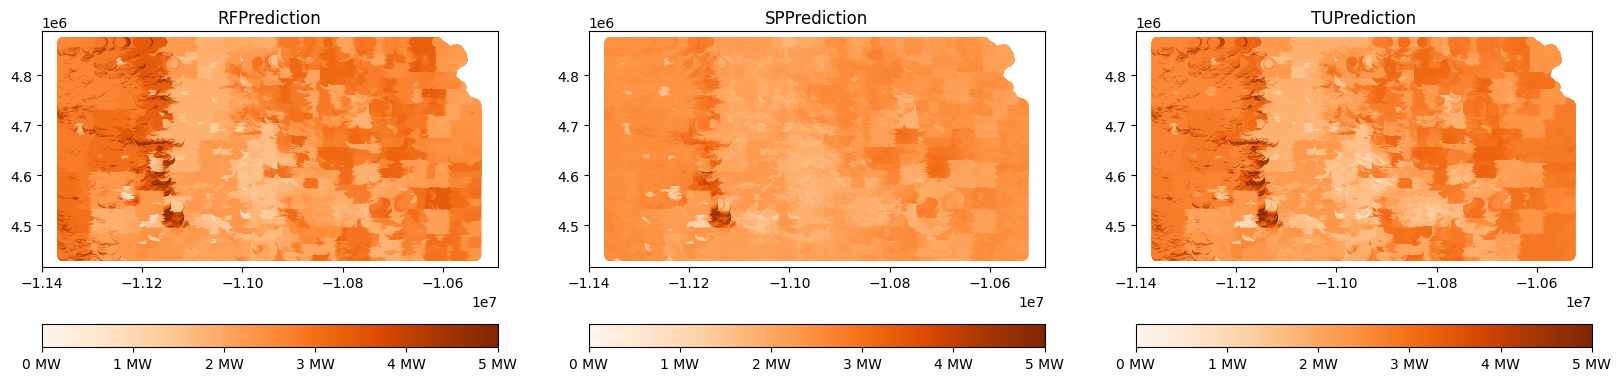

In [52]:
fig,ax=plt.subplots(1,3,figsize=(20,5))
j=0
for i in ['RFPrediction','SPPrediction','TUPrediction']:
    map_gdf.plot(column=i,cmap='Oranges',ax=ax[j],legend=True,legend_kwds={'location':'bottom','format':'%i MW'},vmin=0,vmax=5,markersize=0.5)
    ax[j].set_title(i)
    ax[j].axis('off')
    j+=1
fig.savefig('Prediction Results.png')